In [2]:
import damask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yaml.loader import BaseLoader
import yaml
import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())

The current directory is: 
c:\Users\springnuance\Desktop\DAMASK3-Processing-Project


In [3]:
loading = "linear_UAT_RD"
CPLaw = "DB"
material = "AL"
result = damask.Result(f'postprocess_test_hdf5/{CPLaw}/{material}_{loading}_tensionX.hdf5')


#### Extract output fields from material.yaml

In [4]:
with open(f'create_manual_DAMASK3/material_{material}_{CPLaw}.yaml', 'r') as stream:
    material_yaml = yaml.load(stream, Loader=BaseLoader)
print(material_yaml)

phases = list(material_yaml['phase'].keys())
# if plastic output exists:
all_outputs = material_yaml['phase'][phases[0]]['mechanical']['output']
if 'output' in material_yaml['phase'][phases[0]]['mechanical']['plastic']:
    plastic_outputs = material_yaml['phase'][phases[0]]['mechanical']['plastic']['output']
    outputs = all_outputs + plastic_outputs
else:
    outputs = all_outputs

print(outputs)

# Create an empty DataFrame
df = pd.DataFrame()

{'homogenization': {'SX': {'N_constituents': '1', 'mechanical': {'type': 'pass'}}}, 'phase': {'Aluminum': {'lattice': 'cF', 'mechanical': {'output': ['F', 'P', 'F_e', 'F_p', 'L_p', 'O'], 'elastic': {'type': 'Hooke', 'C_11': '107e9', 'C_12': '52e9', 'C_44': '26e9'}, 'plastic': {'type': 'dislotwin', 'output': ['rho_dip', 'rho_mob'], 'D': '1.525e-05', 'N_sl': ['12'], 'b_sl': ['2.546e-10'], 'tau_0': ['55e6'], 'rho_dip_0': ['1'], 'rho_mob_0': ['1e12'], 'v_0': ['10e-5'], 'Q_sl': ['8.361e-20'], 'p_sl': ['0.8'], 'q_sl': ['1.5'], 'i_sl': ['45'], 'D_0': '0.000623', 'Q_cl': '1.876e-19', 'omega': '4', 'D_a': '7', 'h_sl-sl': ['1', '1', '1', '1', '1', '1', '1']}}}}, 'material': [{'constituents': [{'phase': 'Aluminum', 'O': ['0.8824265782080677', '-0.05608753307113829', '0.08883322634416188', '-0.45856971182502'], 'v': '1.0'}], 'homogenization': 'SX'}, {'constituents': [{'phase': 'Aluminum', 'O': ['0.6134475557126102', '0.6543253967799157', '0.2798496271731801', '-0.34238072038311673'], 'v': '1.0'}],

### The increment and time number

In [5]:
increments = result.increments_in_range(start=0,end=10e9)
print(increments)
print(len(increments))
df["inc"] = increments

times = result.times_in_range(start=0,end=10e9)
print(times)
print(len(times))
df["time"] = times

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140]
41
[0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 66.0, 92.0, 118.0, 144.0, 170.0, 247.5, 325.0, 402.5, 480.0, 557.5, 635.0, 712.5, 790.0, 867.5, 945.0, 1022.5, 1100.0, 1177.5, 1255.0, 1332.5, 1410.0, 1487.5, 1565.0, 1642.5, 1720.0, 1780.0, 1840.0, 1900.0, 1960.0, 2020.0]
41


In [6]:
# https://damask.mpie.de/documentation/examples/add_field_data.html
# add deformation gradient rate F and Piola–Kirchhoff stress P

# We assume that P and F are always in the outputs
result.add_stress_Cauchy('P','F')

result.add_strain('F','U')
result.add_strain('F','V')

# Add the Mises equivalent of the Cauchy stress 'sigma'
result.add_equivalent_Mises('sigma')

# Add the Mises equivalent of the spatial logarithmic strain 'epsilon_V^0.0(F)'
result.add_equivalent_Mises('epsilon_V^0.0(F)')

if 'F_p' in outputs:
    result.add_strain('F_p','U')
    result.add_strain("F_p",'V')
    result.add_equivalent_Mises('epsilon_U^0.0(F_p)')


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


### Aluminum Single Phase

In [7]:
def getMean1DAcrossPhases(result, attribute):
    # Increment -> Phase -> np.array of shape (num_grains_of_phase,)
    # Return np.array of shape (num_increments,)
    allIncrements = result.get(attribute).keys()

    allIncrements = list(allIncrements)
    allPhases = result.get(attribute)[allIncrements[0]].keys()
    allPhases = list(allPhases)
    mean_attribute = []
    attribute_dict = result.get(attribute)

    # for increment in allIncrements:
    #     increment_values = []
    #     for phase in allPhases:
    #         increment_values.append(np.mean(attribute_dict[increment][phase]).item())
    #     mean_attribute.append(np.mean(increment_values).item())
    # return mean_attribute

    for increment in allIncrements:
        increment_values = []
        for phase in allPhases:
            increment_values.extend(attribute_dict[increment][phase])
        mean_attribute.append(np.mean(increment_values).item())
    return mean_attribute

# Plot true stress-true strain curve

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


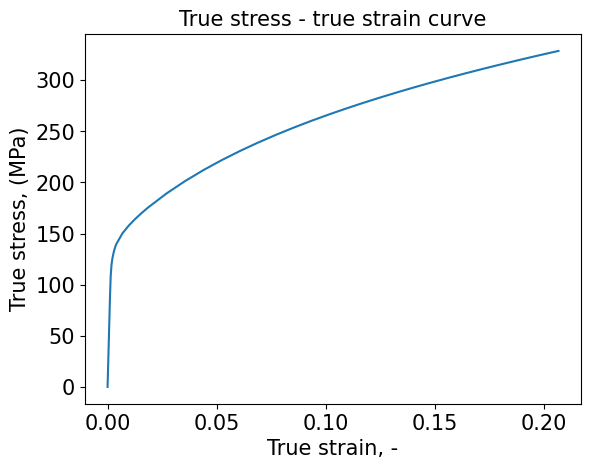

In [8]:
# True stress - true strain curve
# Works for Aluminum PH
trueStress = np.array([np.average(s) for s in result.get('sigma_vM').values()])  * 1e-6
trueStrain = np.array([np.average(e) for e in result.get('epsilon_V^0.0(F)_vM').values()])

# Increment 0 to 140, 40 points output plus increment 0 = 41 points
#print(len(trueStress))
#print(len(trueStrain))

#trueStress = getMeanAcrossPhases(result, 'sigma_vM') 
#trueStrain = getMeanAcrossPhases(result, 'epsilon_V^0.0(F)_vM')
df["Mises(Cauchy)"] = trueStress
df["Mises(ln(V))"] = trueStrain

size = 15
plt.title('True stress - true strain curve',fontsize=size)
plt.xlabel('True strain, -',fontsize=size)
plt.ylabel('True stress, (MPa)',fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.plot(trueStrain, trueStress)


### Stress and strain tensors

In [9]:
F = np.array(list(result.get('F').values()))
print(F.shape) # (41, 64000, 3, 3). 64000 = 40 x 40 x 40 dimension of RVE

# Calculate the mean along the second dimension (number of pixels)
F = np.mean(F, axis=1)
print(F.shape) # (41, 3, 3)
# print(F_p)

epsilonV00F = np.array(list(result.get('epsilon_V^0.0(F)').values()))
print(epsilonV00F.shape) # (41, 64000, 3, 3)

# Calculate the mean along the second dimension (number of pixels)
epsilonV00F = np.mean(epsilonV00F, axis=1)
print(epsilonV00F.shape) # (41, 3, 3)

for i in range(3):
    for j in range(3):
        index = i * 3 + j + 1
        df[f'{index}_f'] = F[:,i,j]
    
for i in range(3):
    for j in range(3):
        index = i * 3 + j + 1
        df[f'{index}_ln(V)'] = epsilonV00F[:,i,j]


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  12% ETA 0:00:00

(41, 64000, 3, 3)
(41, 3, 3)


 ██████████████████████████████████████████████████ 100% ETA 0:00:00


(41, 64000, 3, 3)
(41, 3, 3)


# Plot R-value (Lankford coefficient)

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


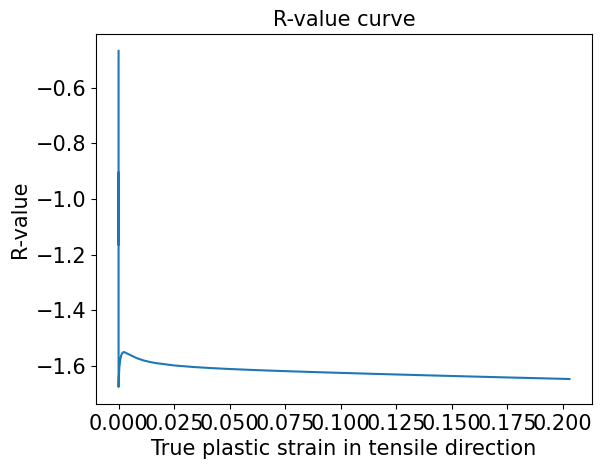

In [10]:
# Lankford coefficient - Plastic strain ratio curve - R-value
# Works for Aluminum PH
epsilon_avg = np.array([np.average(eps,0) for eps in result.get('epsilon_U^0.0(F_p)').values()])
Rvalue_coeff = epsilon_avg[:,1,1]/epsilon_avg[:,2,2]
Rvalue_strain = np.array([np.average(strain) for strain in result.get('epsilon_U^0.0(F_p)_vM').values()])
#print(len(Rvalue_coeff))
#print(len(Rvalue_strain))

df['r-value-coeff'] = Rvalue_coeff
df['r-value-strain'] = Rvalue_strain

size=15
plt.title("R-value curve",fontsize=size)
plt.xlabel("True plastic strain in tensile direction",fontsize=size)
plt.ylabel("R-value",fontsize=size)
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.plot(Rvalue_strain, Rvalue_coeff)

### Dislocation densities

In [11]:
# Add the total mobile and dipole dislocation density
if 'rho_mob' in outputs:
    if CPLaw == 'DB':
        result.add_calculation('np.sum(#rho_mob#,axis=1)','rho_mob_total','1/m2','total mobile dislocation density')
        rho_mob_total = np.array([np.average(s) for s in result.get('rho_mob_total').values()])
        df['rho_mob_total'] = rho_mob_total
if 'rho_dip' in outputs:
    if CPLaw == 'DB':
        result.add_calculation('np.sum(#rho_dip#,axis=1)','rho_dip_total','1/m2','total dislocation dipole density')
        rho_dip_total = np.array([np.average(s) for s in result.get('rho_dip_total').values()])
        df['rho_dip_total'] = rho_dip_total
if 'rho_mob' in outputs and 'rho_dip' in outputs:
    if CPLaw == 'DB':
        result.add_calculation('np.sum(#rho_mob#+#rho_dip#,axis=1)','rho_total','1/m2','total dislocation density') 
        rho_total = rho_mob_total + rho_dip_total
        df['rho_total'] = rho_total 

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


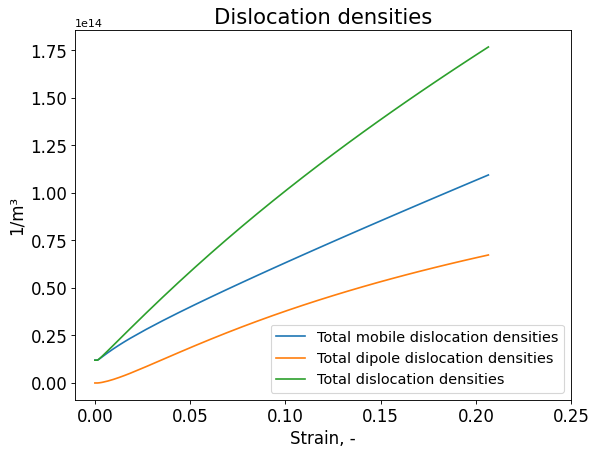

In [12]:
rho_mob_total = np.array([np.average(s) for s in result.get('rho_mob_total').values()])
rho_dip_total = np.array([np.average(s) for s in result.get('rho_dip_total').values()])
rho_total = rho_mob_total + rho_dip_total

trueStrain = [np.average(e) for e in result.get('epsilon_V^0.0(F)_vM').values()]
#print(epsilon)

size=15
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(trueStrain, rho_mob_total, label="Total mobile dislocation densities")
plt.plot(trueStrain, rho_dip_total, label="Total dipole dislocation densities")
plt.plot(trueStrain, rho_total, label="Total dislocation densities")

plt.title(f"Dislocation densities", size=size + 4)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.ylabel('1/m³', size=size)
plt.xlabel("Strain, -", size=size)
plt.legend(loc=4, fontsize=size - 2)

### Write postprocessing data to csv and xlsx fie format

In [13]:
# Save DataFrame as XLSX file
xlsx_filename = f'postprocess_test_hdf5/{CPLaw}_{material}_tensionX.xlsx'
df.to_excel(xlsx_filename, index=False)

# Save DataFrame as CSV file
csv_filename = f'postprocess_test_hdf5/{CPLaw}_{material}_tensionX.txt'
df.to_csv(csv_filename, index=False, sep ='\t')